## Model 2 - Convolutional Neural Network (CNN)

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [6]:
from google.colab import files
import os

uploaded = files.upload()

# Extract
zip_filename = 'listing_images.zip'
os.system(f'unzip {zip_filename} -d .')


Saving listing_images.zip to listing_images.zip


0

In [2]:

# Define dataset path and grades
grades = ['psa 7', 'psa 8', 'psa 9', 'psa 10']
root_dir = 'listing_images'

# Prepare data
data = []
for grade in grades:
    grade_dir = os.path.join(root_dir, grade)
    if os.path.exists(grade_dir):
        for folder in os.listdir(grade_dir):
            image_path = os.path.join(grade_dir, folder, '$_3.JPG')
            if os.path.exists(image_path):
                label = grades.index(grade)
                data.append({'image_path': image_path, 'label': label})

# Convert to a DataFrame and shuffle
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)



## Data Preparation

In [15]:
import tensorflow as tf

# Function to preprocess images inline with your logic
def preprocess_image(image_path, label, target_size=(384, 512)):
    """Preprocess a single image and label."""
    # Load the image
    img = Image.open(image_path.numpy().decode()).convert('RGB')

    # Resize while maintaining aspect ratio
    img.thumbnail(target_size, Image.LANCZOS)

    # Create a new image with black background and paste the resized image
    new_img = Image.new('RGB', target_size, (0, 0, 0))
    paste_x = (target_size[0] - img.size[0]) // 2
    paste_y = (target_size[1] - img.size[1]) // 2
    new_img.paste(img, (paste_x, paste_y))

    # Convert to numpy array and preprocess using ResNet preprocessing
    image_array = np.array(new_img)
    image_array = resnet_preprocess_input(image_array)
    return image_array, label

def preprocess_image(image_path, label):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image to RGB
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    # Resize and pad to the target size
    image = tf.image.resize_with_pad(image, target_height=384, target_width=512)
    # Preprocess for ResNet
    image = resnet_preprocess_input(image)
    return image, label


batch_size = 32

# Create TensorFlow datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['label'].values))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['label'].values))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)




## CNN Model Definition

In [20]:
model = models.Sequential()
model.add(layers.Input(shape=(384, 512, 3)))

# Convolutional layers
for _ in range(3):
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

# Use a Global Average Pooling layer instead of Flatten
model.add(layers.GlobalAveragePooling2D())

# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 384, 512, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 192, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 192, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 96, 128, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 96, 128, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 48, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,132 (94.27 KB)

 Trainable params: 24,132 (94.27 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Define the checkpoint callback (was causing issues so only using earlyStopping currently)
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoint.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Define additional callbacks (not using currently)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-5
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model with callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping]
)








Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 653s 11s/step - accuracy: 0.2609 - loss: 2.7413 - val_accuracy: 0.2860 - val_loss: 1.3834
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 644s 10s/step - accuracy: 0.3020 - loss: 1.3827 - val_accuracy: 0.2860 - val_loss: 1.3762
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 624s 10s/step - accuracy: 0.2777 - loss: 1.3762 - val_accuracy: 0.2754 - val_loss: 1.3775
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 646s 11s/step - accuracy: 0.2855 - loss: 1.3740 - val_accuracy: 0.2860 - val_loss: 1.3786
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 687s 11s/step - accuracy: 0.2850 - loss: 1.3729 - val_accuracy: 0.2733 - val_loss: 1.3845
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 681s 11s/step - accuracy: 0.2823 - loss: 1.3708 - val_accuracy: 0.2733 - val_loss: 1.3790
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 679s 11s/step - accuracy: 0.2942 - loss: 1.3684 - val_accuracy: 0.2754 - val_loss: 1.3808


Our CNN model implements early stopping in the case where the accuracy and loss is not improving. Here we see that in this run through it stops after 7/10 epochs because the accuracy was leveling out and peaked at 0.3020 in epoch 2.

## Fitting graph

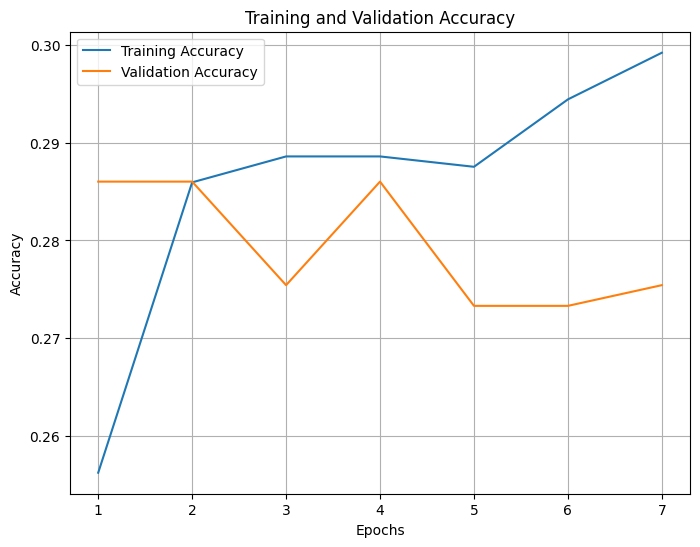

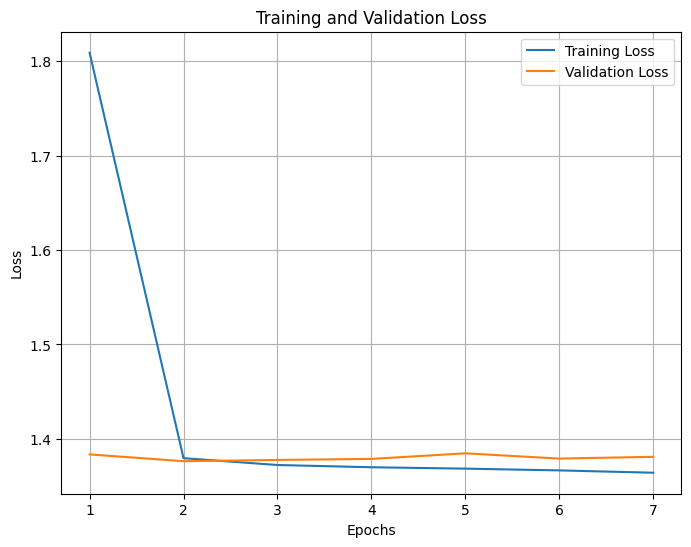

In [22]:
import matplotlib.pyplot as plt

# Extract data from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Insights and Evaluation

### Training Accuracy:

The training accuracy starts relatively low and slowly increases over the epochs, but the increase is very modest, with final accuracy just around 30%.
This indicates that the model is learning but very slowly.

### Validation Accuracy:

The validation accuracy fluctuates throughout the epochs without a clear upward trend.
It also remains quite low, hovering around 28–30%.


The low and fluctuating validation accuracy indicates that the model struggles to generalize to unseen data.

### Training Loss:

The training loss sharply decreases in the first epoch and then stabilizes, but remains relatively high.
This shows that the model is learning but not optimally.

### Validation Loss:

The validation loss remains relatively flat and doesn't show significant improvement. It even seems to slightly diverge from the training loss in later epochs.

- Underfitting: The model is not complex enough to capture the patterns in the data.
- Insufficient Training Data: The dataset might be too small for the model to learn effectively. Although I don't think this is the case as we have a sufficent amount of data images.



## Predictions

In [24]:
predictions = model.predict(val_dataset)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.concatenate([y.numpy() for x, y in val_dataset])


15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step


### confusion matrix

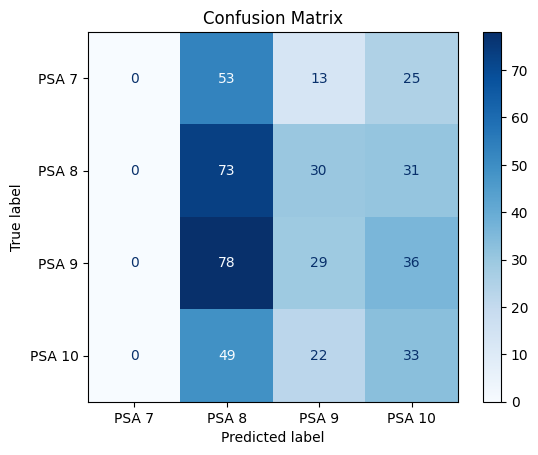

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes, labels=[0, 1, 2, 3])  # Assuming classes are 0, 1, 2, 3

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['PSA 7', 'PSA 8', 'PSA 9', 'PSA 10'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


### Analyze False Positives (FP) and False Negatives (FN)

In [37]:
# Get indices of false positives
fp_indices = np.where((predicted_classes != true_classes) & (predicted_classes != 0))[0]

# Display 10
print("False Positives (First 10):")
for idx in fp_indices[:10]:
    card_identifier = val_df.iloc[idx]['image_path']
    true_label = true_classes[idx]
    predicted_label = predicted_classes[idx]
    print(f"Card Identifier: {card_identifier}, True Label: {true_label}, Predicted: {predicted_label}")




False Positives (First 10):
Card Identifier: listing_images/psa 7/235318662617/$_3.JPG, True Label: 0, Predicted: 1
Card Identifier: listing_images/psa 9/167058421492/$_3.JPG, True Label: 2, Predicted: 1
Card Identifier: listing_images/psa 7/156170337427/$_3.JPG, True Label: 0, Predicted: 3
Card Identifier: listing_images/psa 7/356169459798/$_3.JPG, True Label: 0, Predicted: 2
Card Identifier: listing_images/psa 10/386998064554/$_3.JPG, True Label: 3, Predicted: 2
Card Identifier: listing_images/psa 8/266027203121/$_3.JPG, True Label: 1, Predicted: 3
Card Identifier: listing_images/psa 7/186699122415/$_3.JPG, True Label: 0, Predicted: 1
Card Identifier: listing_images/psa 8/315152398100/$_3.JPG, True Label: 1, Predicted: 3
Card Identifier: listing_images/psa 8/335485541928/$_3.JPG, True Label: 1, Predicted: 2
Card Identifier: listing_images/psa 9/305728916514/$_3.JPG, True Label: 2, Predicted: 1


In [38]:
# Get indices of false negatives
fn_indices = np.where((predicted_classes != true_classes) & (true_classes != 0))[0]

# Display 10
print("\nFalse Negatives (First 10):")
for idx in fn_indices[:10]:
    card_identifier = val_df.iloc[idx]['image_path']
    true_label = true_classes[idx]
    predicted_label = predicted_classes[idx]
    print(f"Card Identifier: {card_identifier}, True Label: {true_label}, Predicted: {predicted_label}")




False Negatives (First 10):
Card Identifier: listing_images/psa 9/167058421492/$_3.JPG, True Label: 2, Predicted: 1
Card Identifier: listing_images/psa 10/386998064554/$_3.JPG, True Label: 3, Predicted: 2
Card Identifier: listing_images/psa 8/266027203121/$_3.JPG, True Label: 1, Predicted: 3
Card Identifier: listing_images/psa 8/315152398100/$_3.JPG, True Label: 1, Predicted: 3
Card Identifier: listing_images/psa 8/335485541928/$_3.JPG, True Label: 1, Predicted: 2
Card Identifier: listing_images/psa 9/305728916514/$_3.JPG, True Label: 2, Predicted: 1
Card Identifier: listing_images/psa 9/335148571079/$_3.JPG, True Label: 2, Predicted: 1
Card Identifier: listing_images/psa 8/335589811929/$_3.JPG, True Label: 1, Predicted: 3
Card Identifier: listing_images/psa 8/267003351149/$_3.JPG, True Label: 1, Predicted: 3
Card Identifier: listing_images/psa 8/266972234338/$_3.JPG, True Label: 1, Predicted: 2


### correct predictions

In [35]:
# Get indices of correct predictions
correct_indices = np.where(predicted_classes == true_classes)[0]

# Display image paths, true labels, and predicted labels for correct predictions
print("\nCorrect Predictions:")
for idx in correct_indices[:10]:  # Limit to the first 10 correct predictions
    card_identifier = val_df.iloc[idx]['image_path']  # Use 'image_path' or appropriate column
    true_label = true_classes[idx]
    predicted_label = predicted_classes[idx]
    print(f"Card Identifier: {card_identifier}, True Label: {true_label}, Predicted: {predicted_label}")




Correct Predictions:
Card Identifier: listing_images/psa 8/326246036610/$_3.JPG, True Label: 1, Predicted: 1
Card Identifier: listing_images/psa 8/326338165366/$_3.JPG, True Label: 1, Predicted: 1
Card Identifier: listing_images/psa 8/205071533118/$_3.JPG, True Label: 1, Predicted: 1
Card Identifier: listing_images/psa 10/135192362390/$_3.JPG, True Label: 3, Predicted: 3
Card Identifier: listing_images/psa 10/404996201380/$_3.JPG, True Label: 3, Predicted: 3
Card Identifier: listing_images/psa 9/356225284362/$_3.JPG, True Label: 2, Predicted: 2
Card Identifier: listing_images/psa 8/305833978440/$_3.JPG, True Label: 1, Predicted: 1
Card Identifier: listing_images/psa 8/315567739454/$_3.JPG, True Label: 1, Predicted: 1
Card Identifier: listing_images/psa 10/235491620973/$_3.JPG, True Label: 3, Predicted: 3
Card Identifier: listing_images/psa 10/375429935098/$_3.JPG, True Label: 3, Predicted: 3


### looking at metrics

In [28]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=['PSA 7', 'PSA 8', 'PSA 9', 'PSA 10'])
print(report)


              precision    recall  f1-score   support

       PSA 7       0.00      0.00      0.00        91
       PSA 8       0.29      0.54      0.38       134
       PSA 9       0.31      0.20      0.24       143
      PSA 10       0.26      0.32      0.29       104

    accuracy                           0.29       472
   macro avg       0.22      0.27      0.23       472
weighted avg       0.23      0.29      0.24       472



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
